In [1]:
import pandas as pd
import numpy as np
import sklearn.linear_model as lm
import matplotlib.pyplot as plt

from pylab import rcParams
rcParams['figure.figsize'] = 14, 4


# 1 Regresión Lineal Ordinaria (LSS)

Se comenzará el informe con la contrucción de un modelo para precedir el precio de una casa. Como datos de entrada se usará un *dataset* con las ventas en el condado de King County, EEUU entre Mayo de 2014 y Mayo de 2015. Para esto, se utilizará una regresión lineal ordinaria basada en LSS (Linear Least Squares)

## a) Ingreso de los datos

Los datos fueron obtenidos de Kaggle, y se encuentran en un archivo CSV. Las características o *features* id (número identificador), date (fecha) y zipcode (código postal) serán descartadas ya que de ante mano podemos suponer que no tienen relación con el precio de la casa.

In [2]:
df = pd.read_csv("kc_house_data.csv",sep = ",",header = 0)
df = df.drop(['id','date','zipcode'], axis=1)

## b) Análisis Descriptivo de los Datos

Primero es útil revisar el tamaño del dataset, junto con todo el resto de las características.

In [3]:
df.shape

(21613, 18)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21613 entries, 0 to 21612
Data columns (total 18 columns):
price            21613 non-null float64
bedrooms         21613 non-null int64
bathrooms        21613 non-null float64
sqft_living      21613 non-null int64
sqft_lot         21613 non-null int64
floors           21613 non-null float64
waterfront       21613 non-null int64
view             21613 non-null int64
condition        21613 non-null int64
grade            21613 non-null int64
sqft_above       21613 non-null int64
sqft_basement    21613 non-null int64
yr_built         21613 non-null int64
yr_renovated     21613 non-null int64
lat              21613 non-null float64
long             21613 non-null float64
sqft_living15    21613 non-null int64
sqft_lot15       21613 non-null int64
dtypes: float64(5), int64(13)
memory usage: 3.0 MB


Tenemos que cada variable representa:

**price**: Es el precio de la casa, para nuestro análisis sera la variable a predecir. 
**bedrooms**: Cantidad de dormitorios que posee la casa. 
**bathrooms**: Cantidad de baños que posee la casa.
**sqft_living**: Pies cuadrados de la casa.
**sqft_lot**: Pies cuadrados del terreno donde se encuentra construida la casa.
**floors**: Cantidad de pisos que posee la casa.       
**waterfront**: Si la casa tiene vista al mar.
**view**:            
**condition**: Condicion en la que se encuentra la casa.       
**grade**: Grado general dado a la unidad de vivienda, basado en el sistema de clasificación del Condado de King.          
**sqft_above**: Metros cuadrados de la casa sin el sotano.       
**sqft_basement**: Metros cuadrados del sotano.
**yr_built**: Año de construccion de la casa.        
**yr_renovated**: Año en que la casa fue renovada.   
**lat**: Latitud.             
**long**: Longitud.            
**sqft_living15**: Tamaño del living room al año 2015.   
**sqft_lot15**: Tamaño del terreno al año 2015.   

In [5]:
df.describe()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,lat,long,sqft_living15,sqft_lot15
count,2.161300e+04,21613.000000,21613.000000,21613.000000,2.161300e+04,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000
mean,5.400881e+05,3.370842,2.114757,2079.899736,1.510697e+04,1.494309,0.007542,0.234303,3.409430,7.656873,1788.390691,291.509045,1971.005136,84.402258,47.560053,-122.213896,1986.552492,12768.455652
std,3.671272e+05,0.930062,0.770163,918.440897,4.142051e+04,0.539989,0.086517,0.766318,0.650743,1.175459,828.090978,442.575043,29.373411,401.679240,0.138564,0.140828,685.391304,27304.179631
min,7.500000e+04,0.000000,0.000000,290.000000,5.200000e+02,1.000000,0.000000,0.000000,1.000000,1.000000,290.000000,0.000000,1900.000000,0.000000,47.155900,-122.519000,399.000000,651.000000
25%,3.219500e+05,3.000000,1.750000,1427.000000,5.040000e+03,1.000000,0.000000,0.000000,3.000000,7.000000,1190.000000,0.000000,1951.000000,0.000000,47.471000,-122.328000,1490.000000,5100.000000
50%,4.500000e+05,3.000000,2.250000,1910.000000,7.618000e+03,1.500000,0.000000,0.000000,3.000000,7.000000,1560.000000,0.000000,1975.000000,0.000000,47.571800,-122.230000,1840.000000,7620.000000
75%,6.450000e+05,4.000000,2.500000,2550.000000,1.068800e+04,2.000000,0.000000,0.000000,4.000000,8.000000,2210.000000,560.000000,1997.000000,0.000000,47.678000,-122.125000,2360.000000,10083.000000
max,7.700000e+06,33.000000,8.000000,13540.000000,1.651359e+06,3.500000,1.000000,4.000000,5.000000,13.000000,9410.000000,4820.000000,2015.000000,2015.000000,47.777600,-121.315000,6210.000000,871200.000000


## c) Transformación de las Variables

Los modelos de regresión lineal múltiple asumen ciertas cosas sobre el *dataset*:

* Las variables dependientes e independientes tienen una relación lineal
* Las variables siguen una distribución normal

Una función entregada por SciKit que nos puede ayudar para el segundo punto es StandardScaler, el cual hace lo que se llama Estandarización o Z-score normalization. Esto es, transformar las variables en sus z-scores a partir de:

$$x - \mu \over \sigma$$

Siendo $\mu$ el promedio de la población y $\sigma$ la desviación estándar de ésta. Esto va a permitir que los datos tengan una media o esperanza centrada en 0, y varianzas bajo el mismo orden de magnitud.

Para el caso de nuestra variable dependiente **precio**, se va a hacer además una transformación logarítmica. Ésta es una práctica común al trabajar con variables referidas a dinero, y tiene varias ventajas:

* Los precios en general tienen *skewness*, o sea, su histograma está desbalanceado, con la mayor parte de los datos acumulados en cierto rango de valores. Una transformacion logarítmica puede ayudar a balancear el histograma (mejorar la simetría), y hacer que su comportamiento sea similar a una distribución normal.
* Los cambios en el valor logarítmico de una variable pueden ser directamente interpretados como cambios porcentuales.
* El logaritmo puede convertir relaciones multiplicativas en relaciones aditivas (como en el caso anterior, donde los cambios son convertidos en adiciones), y por tanto, hace que patrones de crecimiento exponencial se conviertan en patrones lineales, los cuales funcionan mucho mejor con nuestro modelo.

http://www.jerrydallal.com/lhsp/logs.htm
https://www.r-statistics.com/2013/05/log-transformations-for-skewed-and-wide-distributions-from-practical-data-science-with-r/
https://people.duke.edu/~rnau/411log.htm


In [6]:
#Se guarda en la variable X todo el dataset
X = df
#Transformacion Logaritmica
y = np.log(df['price'])

# Se crea un vector "mascara" del largo del dataframe X, 
# y se elige un limite del 70% del dataset para ser usado como conjunto de entrenamiento
# El otro 30% sera un conjunto de prueba
mask = np.zeros(len(X))
limit = int(len(X)*0.7)
mask[:limit] = 1
istrain = (mask== 1)
Xtrain = X[istrain]
ytrain = y[istrain]
Xtest = X[np.logical_not(istrain)]
ytest = y[np.logical_not(istrain)]

# Se quita la columna de precio de X despues de la normalización, ya que esto estara en el vector Y
Xtrain = Xtrain.drop(['price'], axis=1)
Xtest = Xtest.drop(['price'], axis=1)

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().fit(Xtrain)
df_scaled_train = pd.DataFrame(scaler.transform(Xtrain), columns=Xtrain.columns)
df_scaled_train.insert(df_scaled_train.shape[1], 'intercept', np.ones(df_scaled_train.shape[0]))

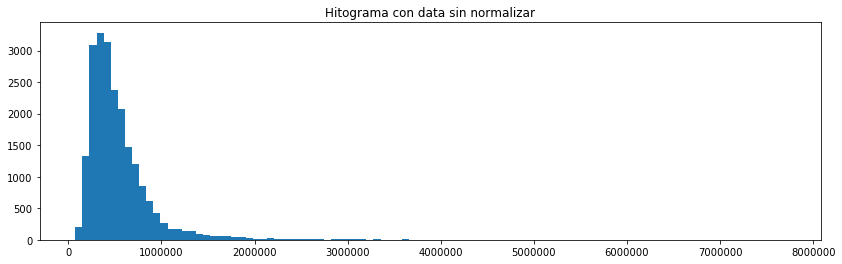

In [8]:
from matplotlib.pylab import hist, show
from pylab import rcParams

plt.title("Hitograma con data sin normalizar")
plt.hist(df['price'],bins=100)
plt.show()

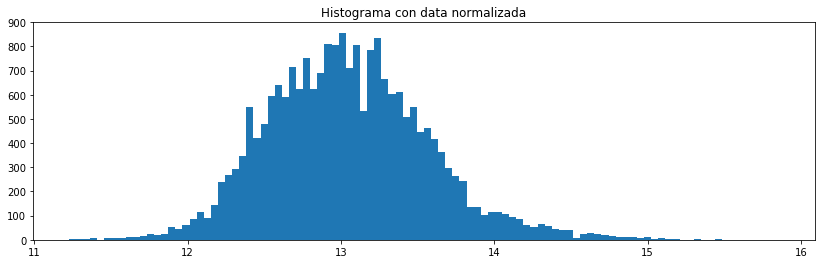

In [9]:
plt.title("Histograma con data normalizada")
plt.hist(np.log(df['price']), bins=100)
plt.show()

In [10]:
#df_scaled_train.describe()

Como vemos, logramos hacer que la media de las variables independientes sea muy cercana a cero, y que logre seguir distribuciones parecidas a una Gaussiana. Para el caso de la variable de precio, obtuvimos una escala distinta, pero también de tipo gaussiana.

## d) Contrucción del Modelo

A continuación se hará la regresión lineal. Recordando que la regresión lineal múltiple se puede ver como la resolución de un sistema de ecuaciones, donde cada elemento del conjunto de respuestas se puede ver como:

$$y_i = \beta_0 1 + \beta_1 x_{i1} + \cdots + \beta_q x_{iq} + \varepsilon_i$$

Sea $n$ el tamaño de la muestra (aquí, 21613) y $q$ el número de parámetros (aquí, 18). La ecuación de regresión lineal múltiple es:

$$ \large Y_{n \times 1} = X_{n \times q} \, \beta_{q \times 1} \, + \, \epsilon_{n \times 1}$$

$$
\begin{bmatrix} y_{1} \\ y_{2} \\ \vdots \\ y_{n} \end{bmatrix} = \begin{bmatrix} 1 & x_{11} & x_{12} & \dots & x_{1p} \\ 1 & x_{21} & x_{22} & \dots & x_{2p} \\ \vdots & \vdots & \vdots & & \vdots \\ 1 & x_{n1} & x_{n2} & \dots & x_{np} \end{bmatrix} \begin{bmatrix} \beta_0 \\ \beta_1 \\ \vdots \\ \beta_p \end{bmatrix} + \begin{bmatrix} \varepsilon_1\\ \varepsilon_2\\ \vdots\\ \varepsilon_n \end{bmatrix}
$$

Donde
* $Y$ es un vector de tamaño $n\times 1$, se le dice *vector de respuesta*
* $\epsilon$ es un vector de tamaño $n\times 1$, se le dice *vector de errores*
* $X$ es una matriz de tamaño $n\times q$, se le dice *matriz de diseño*
* $\beta$ es un vector de tamaño $q\times 1$, se le dice *vector de pendiente*

Ya que el elemento $\beta_0$ va multiplicado por uno, la matriz va a requerir una columna de unos.


http://dept.stat.lsa.umich.edu/~kshedden/Courses/Stat401/Notes/401-multreg.pdf

A la función LinearRegression le enviamos el parámetro **fit_intercept = False** debido a que los datos de precios ya están centrados

In [11]:
import sklearn.linear_model as lm
linreg = lm.LinearRegression(fit_intercept = False)
linreg.fit(df_scaled_train, ytrain)

print('Coeficientes: \n', linreg.coef_)
print('R^2 es: ', linreg.score(df_scaled_train, ytrain))

Coeficientes: 
 [ -8.49291294e-03   5.71610995e-02  -9.76680957e+11   2.25372089e-02
   3.50167932e-02   3.31961975e-02   4.27793925e-02   4.67524770e-02
   1.84380696e-01   8.69576685e+11   4.85410014e+11  -1.04675293e-01
   1.53198242e-02   1.87622070e-01  -4.28771973e-03   8.43200684e-02
  -6.95800781e-03   1.30336745e+01]
R^2 es:  0.767448402495


## e) Análisis de variables: Pesos y Z-score

Tenemos que los pesos asignados a cada variable serán los coeficientes $\hat{\beta}$ estimados en los puntos anteriores mediante el metodo de minimos cuadrados. Por otro lado tenemos que los Z-Score se obtienen siguien $\displaystyle z_i = \frac{\hat{\beta_i}}{\sigma_i\sqrt{v_i}}$, donde $v_i$ es el elemento $i-esimo$ de la diagonal de la matriz $(X^tX)^{-1}$

In [12]:
#Se carga el dataframe de los datos de entrenamiento en una arreglo para poder trabajar con los datos
def zscore(M,betas,sigma):
    #X = np.array(df_scaled_train)
    #X = df_scaled_train.as_matrix()
    X = M
    #Se guarda la traspuesta de la matriz 
    Xt = np.transpose(X)
    #se computa el producto matricial entre la Xt y X 
    XtX = np.dot(Xt,X)
    # Se calcula la matriz de varianza-covarianza
    V = np.linalg.inv(XtX)
    # Se guarda la varianza (diagonal de la matriz)
    Vdiag = np.diag(V)
    #Se calculan los z-score
    z_score = betas/(sigma*np.sqrt(Vdiag))
    return np.array(z_score)

In [13]:
#df_scaled_train = df_scaled_train.drop(['sqft_living','sqft_living15'],axis=1)
#print(ytrain)
#linreg.fit(df_scaled_train, ytrain)
z_score = zscore(df_scaled_train.as_matrix(),linreg.coef_, df_scaled_train.std())
d = {'1. Nombre_regresor' : df_scaled_train.columns,'2. Coeficientes' : pd.Series(linreg.coef_),'3. z-score': pd.Series(z_score)}
print(pd.DataFrame(d))

   1. Nombre_regresor  2. Coeficientes  3. z-score
0            bedrooms    -8.492913e-03   -0.809969
1           bathrooms     5.716110e-02    3.863404
2         sqft_living    -9.766810e+11         NaN
3            sqft_lot     2.253721e-02    1.902607
4              floors     3.501679e-02    3.075526
5          waterfront     3.319620e-02    3.738721
6                view     4.277939e-02    4.439012
7           condition     4.675248e-02    5.263713
8               grade     1.843807e-01   12.203597
9          sqft_above     8.695767e+11         NaN
10      sqft_basement     4.854100e+11         NaN
11           yr_built    -1.046753e-01   -8.581041
12       yr_renovated     1.531982e-02    1.757236
13                lat     1.876221e-01   21.775101
14               long    -4.287720e-03   -0.429781
15      sqft_living15     8.432007e-02    5.983472
16         sqft_lot15    -6.958008e-03   -0.580520
17          intercept     1.303367e+01         inf


/home/vito/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in sqrt
  from ipykernel import kernelapp as app


Como podemos apreciar tenemos que existen 3 coeficientes que son del orden de magnitud de $10^{11}$, los cuales pertenecen a las variables sqft_living, sqft_above y sqft_basement lo que hace que tambien obtengamos z-scores muy grandes para esas variables. Si nos damos cuenta estas variables representan las dimensiones en pies cuadrados de la casa, siendo la primera el tamaño completo, la segunda el tamaño sin contar el sotano y la tercera el tamaño del sotano. Podemos suponer que estas variables pueden poseer un grado de correlacion alto, ya que al sumar sqft_above y sqft_basement deberiamos obtener el tamaño total de la casa es decir sqft_living. Para comprobar lo dicho anteriormente se realizara la siguiente matriz de correlacion:

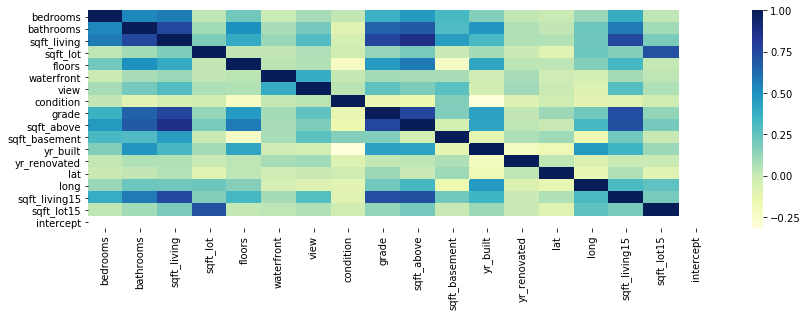

In [14]:
import seaborn as sns

corr = pd.DataFrame.corr(df_scaled_train)

sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns, cmap="YlGnBu")

plt.show()

Como podemos apreciar el indice de correlacion entre $\textbf{sqft_living}$ y $\textbf{sqft_above}$ es $r=0.868037$ mientras que con la variable $\textbf{sqft_basement}$ no es tan alto ($r=0.457049$), esto quizas a que en su mayoria las casas no poseen sotano. Sin embargo tambien podemos notar que el inice de correlacion entre esta variable es alto con otros predictores como $\textbf{bathrooms}$ con un $r=0.760464$, $\textbf{grade}$ con un $r= 0.766096$ y $\textbf{sqft_living15}$ con un $r=0.754939$.

Como podemos ver el supuesto de de que todas las variables son independientes se cae al ver la matriz de correlacion, ya que todos los valores deberian ser cercanos a 0 y aqui tenemos varios coeficientes que estan cerca de $0.5$ o incluso lo sobrepasan como el caso de $\textbf{sqft_living}$. Para solucionar este problema se realizara nuevamente el fiting y se realizara el calculo de los z-score sin considerar la variable $\textbf{sqft_living}$.

In [25]:
df2 = df
df2 = df2.drop(["sqft_living"],axis=1)
X = df2
y2 = np.log(df2['price'])
mask = np.zeros(len(X))
limit = int(len(X)*0.7)
mask[:limit] = 1
istrain = (mask== 1)
Xtrain2 = X[istrain]
ytrain2 = y[istrain]
Xtest2 = X[np.logical_not(istrain)]
ytest2 = y[np.logical_not(istrain)]
Xtrain2 = Xtrain2.drop(['price'], axis=1)
Xtest2 = Xtest2.drop(['price'], axis=1)
scaler = StandardScaler().fit(Xtrain2)
Xtrain2_scaled = pd.DataFrame(scaler.transform(Xtrain2), columns=Xtrain2.columns)
Xtrain2_scaled.insert(Xtrain2_scaled.shape[1], 'intercept', np.ones(Xtrain2_scaled.shape[0]))

linreg.fit(Xtrain2_scaled, ytrain2)
z_score2 = zscore(Xtrain2_scaled.as_matrix(),linreg.coef_,Xtrain2_scaled.std())
d2 = {'1. Nombre_regresor' : Xtrain2_scaled.columns,'2. Coeficientes' : pd.Series(linreg.coef_),'3. z-score': pd.Series(z_score2)}
print(pd.DataFrame(d2))


   1. Nombre_regresor  2. Coeficientes  3. z-score
0            bedrooms        -0.008086   -0.771117
1           bathrooms         0.055111    3.724857
2            sqft_lot         0.022873    1.930916
3              floors         0.035505    3.118415
4          waterfront         0.033366    3.757811
5                view         0.042595    4.419879
6           condition         0.046360    5.219470
7               grade         0.184577   12.216620
8          sqft_above         0.096628    5.358861
9       sqft_basement         0.060561    5.252478
10           yr_built        -0.104759   -8.587932
11       yr_renovated         0.015266    1.751052
12                lat         0.187880   21.804983
13               long        -0.004031   -0.404072
14      sqft_living15         0.084412    5.990017
15         sqft_lot15        -0.007149   -0.596438
16          intercept        13.033501         inf


Como podemos ver el efecto que tiene el quitar esta variable es bastante significativo, ahora los valores de los coeficientes y z-score no presentan ningun valor atipico.

## f) K-fold cross-Validation

El sobreajuste es una complicacion que poseen la mayoria de algoritmos de machine learning, la cual conciste en ajustarse a caracteristicas muy especificas de los datos de entrenamiento provocando que el modelo pierda la capacidad de generalización. Una forma de lidiar con este problema es realizar una validacion cruzadada de los datos.

Para este item se usara el metodo de K-fold cross-validation con $k=5$ y $k=10$ respectivamente.


In [26]:
#Se normaliza la data de test
#scaler_test = StandardScaler().fit(Xtest)
x_test2 = pd.DataFrame(scaler.transform(Xtest2),columns=Xtest2.columns)
#x_test = x_test.drop(["sqft_living"],axis=1)

#Se agrega la columna "intercept"
x_test2.insert(x_test2.shape[1], 'intercept', np.ones(x_test.shape[0]))

#linreg = lm.LinearRegression(fit_intercept = False)

linreg.fit(x_test2, ytest2)
yhat_test = linreg.predict(x_test2)
#Error estandar promedio cuadrado
mse_test = np.mean(np.power(yhat_test - ytest2, 2))
print("Error estandar promedio", mse_test)
from sklearn.model_selection import KFold
Xm = Xtrain2_scaled.as_matrix()
ym = ytrain2.as_matrix()
print("R^2 es: ",linreg.score(x_test2, ytest2))

Error estandar promedio 0.06245798967315822
R^2 es:  0.773397418665


In [27]:
kf = KFold(n_splits=10)
mse_cv = 0
for train, val in kf.split(Xm):
    #train -> indices de cada fold para la data de entreamiento
    #val -> indice de cada fold para la data de test
    cross_scaler = StandardScaler().fit(Xm[train])
    df_cross_train = pd.DataFrame(cross_scaler.transform(Xm[train]),columns=Xtrain.columns)
    df_cross_train.insert(df_cross_train.shape[1], 'intercept',np.ones(df_cross_train.shape[0]))
    linreg = lm.LinearRegression(fit_intercept = False)
    #Por cada iteracion se recalculan los coeficientes
    linreg.fit(df_cross_train, ym[train])
    #Se normalizan los datos de test
    df_cross_test = pd.DataFrame(cross_scaler.transform(Xm[val]),columns=Xtrain.columns)
    df_cross_test.insert(df_cross_test.shape[1], 'intercept', np.ones(df_cross_test.shape[0]))
    #Se obtiene la nueva prediccion
    yhat_val = linreg.predict(df_cross_test)
    mse_fold = np.mean(np.power(yhat_val - ym[val], 2))
    #print("Error del fold", mse_fold)
    mse_cv += mse_fold
mse_cv = mse_cv/10
print("Error promedio para k=10 ", mse_cv)

Error promedio para k=10  0.0646829054256


In [28]:
kf5 = KFold(n_splits=5)
mse_cv_k5 = 0
for train_k5, val_k5 in kf5.split(Xm):
    #train -> indices de cada fold para la data de entreamiento
    #val -> indice de cada fold para la data de test
    cross_scaler_k5 = StandardScaler().fit(Xm[train_k5])
    df_cross_train_k5 = pd.DataFrame(cross_scaler_k5.transform(Xm[train_k5]),columns=Xtrain.columns)
    df_cross_train_k5.insert(df_cross_train_k5.shape[1], 'intercept',np.ones(df_cross_train_k5.shape[0]))
    linreg = lm.LinearRegression(fit_intercept = False)
    #Por cada iteracion se recalculan los coeficientes
    linreg.fit(df_cross_train_k5, ym[train_k5])
    #Se normalizan los datos de test
    df_cross_test_k5 = pd.DataFrame(cross_scaler_k5.transform(Xm[val_k5]),columns=Xtrain.columns)
    df_cross_test_k5.insert(df_cross_test_k5.shape[1], 'intercept', np.ones(df_cross_test_k5.shape[0]))
    #Se obtiene la nueva prediccion
    yhat_val_k5 = linreg.predict(df_cross_test_k5)
    mse_fold_k5 = np.mean(np.power(yhat_val_k5 - ym[val_k5], 2))
    #print("Error del fold", mse_fold_k5)
    mse_cv_k5 += mse_fold_k5
mse_cv_k5 = mse_cv/5
print("Error promedio para k=5 ", mse_cv_k5)

Error promedio para k=5  0.0129365810851


In [30]:
kf15 = KFold(n_splits=15)
mse_cv_k15 = 0
for train_k15, val_k15 in kf15.split(Xm):
    #train -> indices de cada fold para la data de entreamiento
    #val -> indice de cada fold para la data de test
    cross_scaler_k15 = StandardScaler().fit(Xm[train_k15])
    df_cross_train_k15 = pd.DataFrame(cross_scaler_k15.transform(Xm[train_k15]),columns=Xtrain.columns)
    df_cross_train_k15.insert(df_cross_train_k15.shape[1], 'intercept',np.ones(df_cross_train_k15.shape[0]))
    linreg = lm.LinearRegression(fit_intercept = False)
    #Por cada iteracion se recalculan los coeficientes
    linreg.fit(df_cross_train_k15, ym[train_k15])
    #Se normalizan los datos de test
    df_cross_test_k15 = pd.DataFrame(cross_scaler_k15.transform(Xm[val_k15]),columns=Xtrain.columns)
    df_cross_test_k15.insert(df_cross_test_k15.shape[1], 'intercept', np.ones(df_cross_test_k15.shape[0]))
    #Se obtiene la nueva prediccion
    yhat_val_k15 = linreg.predict(df_cross_test_k15)
    mse_fold_k15 = np.mean(np.power(yhat_val_k15 - ym[val_k15], 2))
    #print("Error del fold", mse_fold_k5)
    mse_cv_k15 += mse_fold_k15
mse_cv_k15 = mse_cv/15
print("Error promedio para k=15 ", mse_cv_k15)

Error promedio para k=15  0.00431219369504


Vemos que el error varía demasiado entre cada ejercicio de cross-validation. Por lo tanto, podemos concluír que el modelo está **sobreajustado**.

## j) Análisis del error y normalidad de los datos

In [33]:
import scipy.stats as stats
from scipy.stats import norm

Primero realizaremos la prueba usando el dataframe de entrenamiento que tiene la variable "sqft_living" donde obtenemos la sguientes graficas

In [34]:
# se calcula la prediccion hecha por el modelo del target usando los datos de entrenamiento.
Xtrain = np.array(df_scaled_train)
yhat_train = linreg.predict(Xtrain)
#Se calcula el error o residuo usando los valores reales y los obteidos por la prediccion del modelo
e = np.array(ytrain) - yhat_train

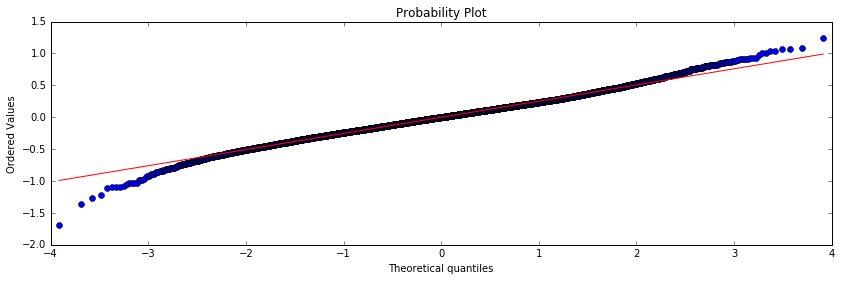

In [35]:
#Se realiza un grafico de probabilidad, el cual nos entregara el mismo resultado que un QQplot ya que n es grande.
stats.probplot(e, dist="norm", plot=plt)
plt.show()

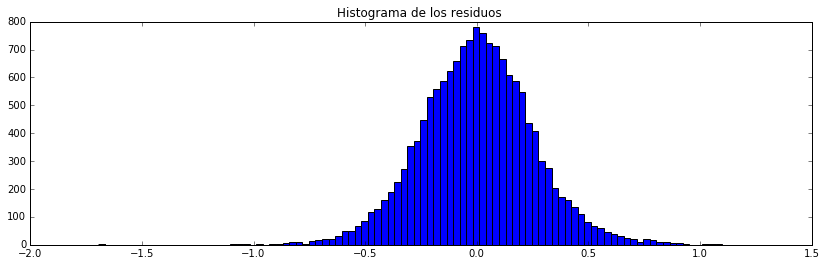

In [36]:
plt.title("Histograma de los residuos ")
plt.hist(e,bins=100)
plt.show()

Como podemos ver los datos en el QQplot se ve bastante bien excepto por los ordenes de magnitud de los ejes. por otro lado mirando el histograma de los residuos podemos apreciar que la concentracion de datos esta un poco inclinada hacia el lado derecho.

Ahora realizaremos las pruebas usando los datos de entenamiento sin la variable "sqft_living" 

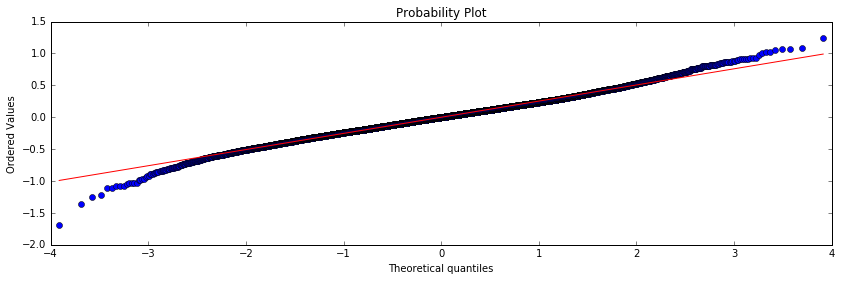

In [37]:
#linreg.fit(df_scaled_train, ytrain)
Xtrain2 = np.array(df_scaled_train2)
linreg.fit(Xtrain2,ytrain2)
yhat_train2 = linreg.predict(Xtrain2)
#Se calcula el error o residuo usando los valores reales y los obteidos por la prediccion del modelo
e2 = np.array(ytrain2) - yhat_train2
stats.probplot(e2, dist="norm", plot=plt)
plt.show()

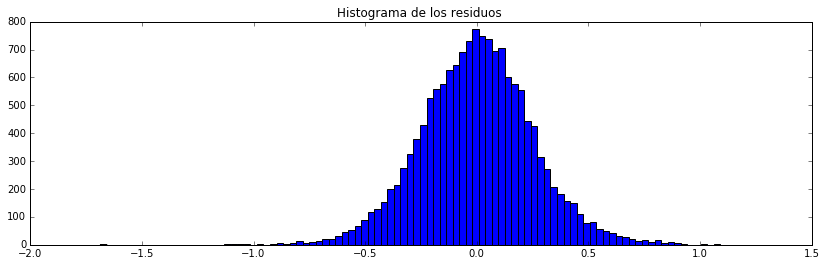

In [38]:
plt.title("Histograma de los residuos ")
plt.hist(e2,bins=100)
plt.show()

podemos ver claramente como mejora el ajuste de los datos en el QQplot y ver como la distribucion de los datos es practicamente una campana de gauss. 

V

## 1-h)

In [31]:
df_A = df.sample(3000)
print(df_A.shape)
frames = []
valor = np.log(df.price)
print(np.max(valor))
print(np.arange(int(np.min(valor)),int(np.max(valor))+1,0.5))
for z in np.arange(int(np.min(valor)),int(np.max(valor))+1,0.5):
    frames.append(df[(np.log(df.price) >= z) & (np.log(df.price) < z+0.5)].head(500))
df_B = pd.concat(frames).sample(3000)
print(df_B.shape)
print(df_A == df_B)
X_A = df_A.iloc[:,1:].values
y_A = df_A.price
X_B = df_B.iloc[:,1:].values
y_B = df_B.price
from sklearn.model_selection import train_test_split
Xtrain_A, Xval_A, ytrain_A, yval_A = train_test_split(X_A, y_A, test_size=0.3, random_state=42)
Xtrain_B, Xval_B, ytrain_B, yval_B = train_test_split(X_B, y_B, test_size=0.3, random_state=42)

(3000, 18)
15.8567308868
[ 11.   11.5  12.   12.5  13.   13.5  14.   14.5  15.   15.5]
(3000, 18)


ValueError: Can only compare identically-labeled DataFrame objects

## 3. Regularización: Ridge Regression y Lasso

Con tal de generar un modelo lineal para nuestro problema, que logre evitar sobreajustes, se probarán los algoritmos de regularización: Ridge Regression y Lasso. Se harán pruebas con variados valores de *alpha* (parámetro para cada algoritmo, que define la penalización a cada atributo de menor importancia al modelo), y se verá cómo cambian los coeficientes de cada característica a medida que cambia este *alpha*.

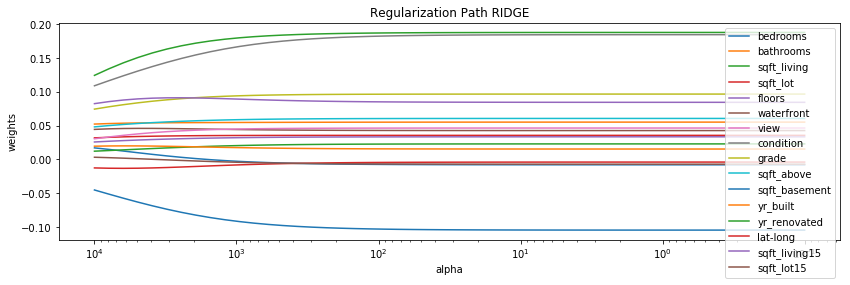

In [44]:
from sklearn.linear_model import Ridge
import matplotlib.pylab as plt
Dtrain = Xtrain2_scaled.copy()
Dtrain = Dtrain.drop('intercept', axis=1)
names_regressors = ["bedrooms","bathrooms","sqft_living","sqft_lot","floors","waterfront","view",
"condition","grade","sqft_above","sqft_basement","yr_built","yr_renovated","lat-long",
"sqft_living15","sqft_lot15"]
alphas_ = np.logspace(4,-1,base=10)
coefs = []
model = Ridge(fit_intercept=True, solver='svd')
for a in alphas_:
    model.set_params(alpha=a)
    model.fit(Dtrain, ytrain)
    coefs.append(model.coef_)
ax = plt.gca()
for y_arr, label in zip(np.squeeze(coefs).T, names_regressors):
    #print(alphas_.shape)
    #print(y_arr.shape)
    plt.plot(alphas_, y_arr, label=label)
plt.legend()
ax.set_xscale('log')
ax.set_xlim(ax.get_xlim()[::-1]) # reverse axis
plt.xlabel('alpha')
plt.ylabel('weights')
plt.title('Regularization Path RIDGE')
plt.axis('tight')
plt.legend(loc=1)
plt.show()

Podemos ver que Ridge Regression, en general, reduce o penaliza los pesos de las características menos importantes (las de menor varianza, acercándolas a cero). Esta penalización aumenta a medida que aumenta el valor de *alpha*, sin embargo, en este caso las penalizaciones van a ser similares para valores bajos de *alpha*, y sólo con valores extremadamente altos, las penalizaciones serán mayores.

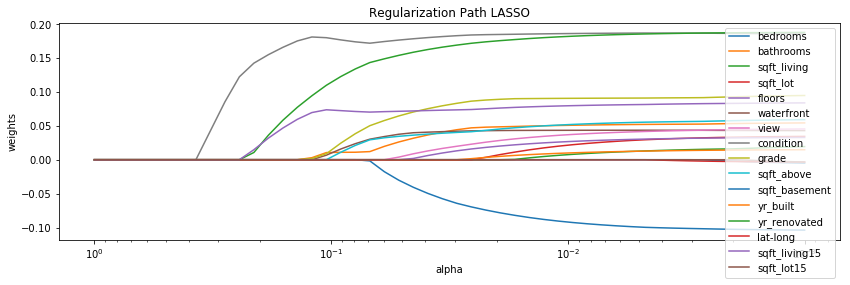

In [36]:
from sklearn.linear_model import Lasso
import matplotlib.pylab as plt
Dtrain = Xtrain2_scaled.copy()
Dtrain = Dtrain.drop('intercept', axis=1)
names_regressors = ["bedrooms","bathrooms","sqft_living","sqft_lot","floors","waterfront","view",
"condition","grade","sqft_above","sqft_basement","yr_built","yr_renovated","lat-long",
"sqft_living15","sqft_lot15"]
alphas_ = np.logspace(0,-3,base=10) # Otro conjunto de alphas
coefs = []
model = Lasso(fit_intercept=True)
for a in alphas_:
    model.set_params(alpha=a)
    model.fit(Dtrain, ytrain)
    coefs.append(model.coef_)
ax = plt.gca()
for y_arr, label in zip(np.squeeze(coefs).T, names_regressors):
    #print(alphas_.shape)
    #print(y_arr.shape)
    plt.plot(alphas_, y_arr, label=label)
plt.legend()
ax.set_xscale('log')
ax.set_xlim(ax.get_xlim()[::-1]) # reverse axis
plt.xlabel('alpha')
plt.ylabel('weights')
plt.title('Regularization Path LASSO')
plt.axis('tight')
plt.legend(loc=1)
plt.show()

Podemos ver que el caso para Lasso es distinto. Lasso, en general, llega a eliminar los coeficientes de las características de menor varianza

In [38]:
from sklearn.linear_model import Lasso
MSE = lambda y,yhat: np.mean(np.power(y-yhat,2))
Xm = Xtrain.as_matrix()
ym = ytrain.as_matrix()
from sklearn import cross_validation
k_fold = cross_validation.KFold(len(Xm),10)
best_cv_mse = float("inf")
model = Lasso(fit_intercept=True)
mse_list_k10 = []
for a in alphas_:
    model.set_params(alpha=a)
    for train,vald in k_fold:
        cross_scaler = StandardScaler().fit(Xm[train])
        df_cross_train = pd.DataFrame(cross_scaler.transform(Xm[train]),
        columns=Xtrain.columns)
        df_cross_train.insert(df_cross_train.shape[1], 'intercept',
        np.ones(df_cross_train.shape[0]))
        df_cross_test = pd.DataFrame(cross_scaler.transform(Xm[vald]),
        columns=Xtrain.columns)
        df_cross_test.insert(df_cross_test.shape[1], 'intercept',
        np.ones(df_cross_test.shape[0]))
        mse_list_k10.append(MSE(model.fit(df_cross_train,
        ym[train]).predict(df_cross_test),ym[vald]))
    if np.mean(mse_list_k10) < best_cv_mse:
        best_cv_mse = np.mean(mse_list_k10)
        best_alpha = a
        print("Mejor alpha es: ", best_alpha, " , MSE(CV) es: " ,best_cv_mse)

/home/vito/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


Mejor alpha es:  1.0  , MSE(CV) es:  0.277498496095
Mejor alpha es:  0.568986602902  , MSE(CV) es:  0.277498496095
Mejor alpha es:  0.323745754282  , MSE(CV) es:  0.2739696934
Mejor alpha es:  0.281176869797  , MSE(CV) es:  0.268229377715
Mejor alpha es:  0.244205309455  , MSE(CV) es:  0.261532320448
Mejor alpha es:  0.212095088792  , MSE(CV) es:  0.254161983117
Mejor alpha es:  0.184206996933  , MSE(CV) es:  0.246260895908
Mejor alpha es:  0.159985871961  , MSE(CV) es:  0.238321060662
Mejor alpha es:  0.138949549437  , MSE(CV) es:  0.230590798759
Mejor alpha es:  0.120679264064  , MSE(CV) es:  0.223225427117
Mejor alpha es:  0.104811313415  , MSE(CV) es:  0.216299631015
Mejor alpha es:  0.0910298177992  , MSE(CV) es:  0.209776555616
Mejor alpha es:  0.0790604321091  , MSE(CV) es:  0.203667017863
Mejor alpha es:  0.0686648845004  , MSE(CV) es:  0.197972734083
Mejor alpha es:  0.0596362331659  , MSE(CV) es:  0.192606480831
Mejor alpha es:  0.0517947467923  , MSE(CV) es:  0.187552263023


## 4. Películas

Tenemos 145256 características, debido a todas las combinaciones de palabras posibles de las críticas/reviews de cada película.

Son 1147 elementos de entrenamiento, 254 elementos de prueba, y 317 elementos para el cross-validation.

Se comenzará cargando los datos.

In [14]:
import pandas as pd
import numpy as np
from scipy.sparse import csc_matrix
from scipy.io import mmread
from sklearn.metrics import mean_squared_error


#X_movies = pd.SparseDataFrame( csr_matrix(mmread('train.x.mm')) )
X_movies = csc_matrix(mmread('train.x.mm'))
y_movies = np.loadtxt('train.y.dat')
X_movies_dev = csc_matrix(mmread('dev.x.mm'))
y_movies_dev = np.loadtxt('dev.y.dat')
X_movies_test = csc_matrix(mmread('test.x.mm'))
y_movies_test = np.loadtxt('test.y.dat')

Intentando hacer una regresión lineal convencional, obtenemos resultados mediocres con un error muy alto.

In [15]:
import sklearn.linear_model as lm
model = lm.LinearRegression(fit_intercept = False)
model.fit(X_movies, y_movies)
print("Usando regresión lineal ordinaria, sin preprocesamiento, R^2 es: ", model.score(X_movies_test, y_movies_test))
y_movies_pred = model.predict(X_movies_test)
print("MSE: ", mean_squared_error(y_movies_test, y_movies_pred))

Usando regresión lineal ordinaria, sin preprocesamiento, R^2 es:  0.590315276123
MSE:  1.95097276693e+14


Antes de probar otros modelos, ya que la variable objetivo será la ganancia de las películas, se hará una **Transformación Logarítmica** a los y.

In [18]:
y_movies = np.log(y_movies)
y_movies_dev = np.log(y_movies_dev)
y_movies_test = np.log(y_movies_test)

In [19]:
X_movies_bak = X_movies
y_movies_bak = y_movies
X_movies_test_bak = X_movies_test
y_movies_test_bak = y_movies_test

X_movies = X_movies_bak
y_movies = y_movies_bak
X_movies_test = X_movies_test_bak
y_movies_test = y_movies_test_bak

In [20]:
X_movies = X_movies_bak
y_movies = y_movies_bak
X_movies_test = X_movies_test_bak
y_movies_test = y_movies_test_bak

Según la documentación de Scikit, no se debe usar estandarización mediante StandardScaler con datos *sparse* debido a que se arruinaría su estructura. Por lo tanto, se recomienda usar MaxAbsScaler.

In [21]:
#Scaling del dataset
from sklearn.preprocessing import MaxAbsScaler
scaler_movies = MaxAbsScaler().fit(X_movies) # Para matriz sparse
X_scaled_movies_train = scaler_movies.transform(X_movies)

# Se ingresa columna de unos, que son los pesos o coeficientes del primer parametro (el intercepto, beta_0)
from scipy.sparse import hstack
matriz_de_unos = csc_matrix(np.ones(X_scaled_movies_train.shape[0])[:, None])
#print(matriz_de_unos.shape)
#print(X_scaled_movies_train.shape)
X_scaled_movies_train = hstack((X_scaled_movies_train, matriz_de_unos))
#print(X_scaled_movies_train.shape)

model_movies = lm.LinearRegression(fit_intercept = False)
model_movies.fit(X_scaled_movies_train, y_movies)


scaler_movies_test = MaxAbsScaler().fit(X_movies_test) # Para matriz sparse
X_scaled_movies_test = scaler_movies_test.transform(X_movies_test)
matriz_de_unos = csc_matrix(np.ones(X_scaled_movies_test.shape[0])[:, None])
X_scaled_movies_test = hstack((X_scaled_movies_test, matriz_de_unos))
r2_2 = model_movies.score(X_scaled_movies_test, y_movies_test)
print("Usando regresión lineal ordinaria, con estandarizacion MaxAbsScaler, R^2 es: ", r2_2)
print("MSE: ", mean_squared_error(y_movies_test, model_movies.predict(X_scaled_movies_test)))

Usando regresión lineal ordinaria, con estandarizacion MaxAbsScaler, R^2 es:  0.292591085974
MSE:  7.86873099037


Debido a que tenemos demasiadas características, vamos a intentar hacer Feature Selection.

Se comenzará con un algoritmo de selección simple: VarianceThreshold, el cual elimina las características que tengan una varianza menor a cierto *threshold*.

Pensando en que este dataset tiene muchas variables binarias, si es que queremos eliminar las variables que tienen el mismo valor en 95% de las muestras, podemos obtener este *threshold* de la varianza usando la fórmula de varianza de la función de Bernoulli:

$$Var[X] = p (1-p)$$


In [22]:
from sklearn.feature_selection import VarianceThreshold

var_threshold = (.95 * (1 - .95))
sel = VarianceThreshold(threshold=var_threshold)
#X_movies_fs_var = sel.fit_transform(X_movies)
#X_movies_test_fs_var = sel.transform(X_movies_test)
X_movies_fs_var = sel.fit_transform(X_scaled_movies_train)
X_movies_test_fs_var = sel.transform(X_scaled_movies_test)

In [23]:
#print(X_movies.shape)
#print(X_movies_test.shape)
print(X_movies_fs_var.shape)
print(X_movies_test_fs_var.shape)

(1147, 193)
(254, 193)


Con esta selección sólo quedan 193 variables.

In [24]:
import sklearn.linear_model as lm
model = lm.LinearRegression(fit_intercept = False)
model.fit(X_movies_fs_var, y_movies)
print("Usando regresión lineal ordinaria, al usar feat. selection, R^2 es: ", model.score(X_movies_test_fs_var, y_movies_test))
print("MSE: ", mean_squared_error(y_movies_test, model.predict(X_movies_test_fs_var)))

Usando regresión lineal ordinaria, al usar feat. selection, R^2 es:  0.739061296726
MSE:  2.90250295173


In [25]:
print( "Numero de atributos que quedaron con pesos no nulos: ", np.count_nonzero(model.coef_) )
import linecache
for i in (np.nonzero(model.coef_)[0]):
    print(linecache.getline('vocab', i+1).split()[0], " ", end='')

Numero de atributos que quedaron con pesos no nulos:  193
VV_choke  VV_being  NY_crime  VV_himself  NY_producer  VV_de  EW_fake  VV_appear  NY_<TOKNUM>  VA_gangster  NY_pervasive  NY_hard  NY_states  VV_deep  VA_more  NY_clear  VV_neighborhood  VV_spite  NY_imperative  NY_rape  NY_exposition  NY_diabolical  VV_story  NY_silent  VA_rep  VA_relationship  VA_iffy  VV_crazy  NY_age  VA_topic  NY_together  VA_plot  VA_joey  EW_high  NY_tina  NY_neighborhood  NY_insist  NY_class  NY_persian  EW_knockoff  NY_touch  VA_implication  NY_time  NY_relish  NY_not  VA_court  VA_tech  NY_agent  NY_connect  NY_only  VV_join  VV_marsden  VV_up  VV_enable  VV_his  VA_well  VV_knee  VA_all  VA_wolf  VV_mostly  VA_story  VA_thanks  NY_half  VA_storm  VA_philadelphia  VA_informant  VA_rac  NY_women  VV_watch  VV_muck  NY_packed  VA_gulf  VV_blood  EW_face  NY_drug  VA_cousin  VV_returns  NY_city  NY_guy  NY_front  VA_kid  NY_harvey  NY_hysterical  NY_exit  NY_without  NY_wire  NY_violence  VV_vincent  VV_c

Obtuvimos un $R^2$ mejor que antes, pero el error aún es significativo.

Ahora vamos a intentar **Recursive feature elimination**, lo cual es básicamente ir probando cierto estimador (en este caso, regresión lineal) eliminando variables (características) una en una hasta llegar a cierto número (por defecto, la mitad de las variables iniciales).

In [85]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import f_regression
from sklearn.feature_selection import mutual_info_regression
from sklearn.feature_selection import RFE

from sklearn.feature_selection import VarianceThreshold

var_threshold = (.96 * (1 - .96))
sel = VarianceThreshold(threshold=var_threshold)
X_movies_fs_var = sel.fit_transform(X_scaled_movies_train)
X_movies_test_fs_var = sel.transform(X_scaled_movies_test)

print(X_movies_fs_var.shape)
print(y_movies.shape)
print(X_movies_test_fs_var.shape)

#sel = SelectKBest(f_regression, k=2500)
sel = RFE(lm.LinearRegression(fit_intercept = False), n_features_to_select=100)

#sel = SelectKBest(chi2, k=3750)
#X_movies_fs_var = sel.fit_transform(X_movies)
#X_movies_test_fs_var = sel.transform(X_movies_test)

#X_movies_fs_kb = sel.fit_transform(X_movies, y_movies)
#X_movies_test_fs_kb = sel.transform(X_movies_test)
X_movies_fs_kb = sel.fit_transform(X_movies_fs_var, y_movies)
X_movies_test_fs_kb = sel.transform(X_movies_test_fs_var)
#print(X_movies.shape)
#print(X_movies_test.shape)
#X_movies = sel.fit_transform(X_movies, y_movies)
#X_movies_test = sel.transform(X_movies_test)
print(X_movies_fs_kb.shape)
print(X_movies_test_fs_kb.shape)

(1147, 429)
(1147,)
(254, 429)
(1147, 100)
(254, 100)


In [86]:
import sklearn.linear_model as lm
model = lm.LinearRegression(fit_intercept = False)
model.fit(X_movies_fs_kb, y_movies)
print("Usando regresión lineal ordinaria, al usar feat. selection, R^2 es: ", model.score(X_movies_test_fs_kb, y_movies_test))
print("MSE: ", mean_squared_error(y_movies_test, model.predict(X_movies_test_fs_kb)))

Usando regresión lineal ordinaria, al usar feat. selection, R^2 es:  0.739637171099
MSE:  2.89609732065


In [87]:
print( "Numero de atributos que quedaron con pesos no nulos: ", np.count_nonzero(model.coef_) )
import linecache
for i in (np.nonzero(model.coef_)[0]):
    print(linecache.getline('vocab', i+1).split()[0], " ", end='')

Numero de atributos que quedaron con pesos no nulos:  100
VV_choke  VV_being  NY_crime  VV_himself  NY_producer  VV_de  EW_fake  VV_appear  NY_<TOKNUM>  VA_gangster  NY_pervasive  NY_hard  NY_states  VV_deep  VA_more  NY_clear  VV_neighborhood  VV_spite  NY_imperative  NY_rape  NY_exposition  NY_diabolical  VV_story  NY_silent  VA_rep  VA_relationship  VA_iffy  VV_crazy  NY_age  VA_topic  NY_together  VA_plot  VA_joey  EW_high  NY_tina  NY_neighborhood  NY_insist  NY_class  NY_persian  EW_knockoff  NY_touch  VA_implication  NY_time  NY_relish  NY_not  VA_court  VA_tech  NY_agent  NY_connect  NY_only  VV_join  VV_marsden  VV_up  VV_enable  VV_his  VA_well  VV_knee  VA_all  VA_wolf  VV_mostly  VA_story  VA_thanks  NY_half  VA_storm  VA_philadelphia  VA_informant  VA_rac  NY_women  VV_watch  VV_muck  NY_packed  VA_gulf  VV_blood  EW_face  NY_drug  VA_cousin  VV_returns  NY_city  NY_guy  NY_front  VA_kid  NY_harvey  NY_hysterical  NY_exit  NY_without  NY_wire  NY_violence  VV_vincent  VV_c

In [ ]:


from sklearn.feature_selection import SelectPercentile
from sklearn.feature_selection import chi2

sel = SelectPercentile(chi2, k=20)

#sel = SelectKBest(chi2, k=3750)
#X_movies_fs_var = sel.fit_transform(X_movies)
#X_movies_test_fs_var = sel.transform(X_movies_test)
print(X_movies.shape)
print(y_movies.shape)
print(X_movies_test.shape)
X_movies_fs_kb = sel.fit_transform(X_movies, y_movies.astype(int))
X_movies_test_fs_kb = sel.transform(X_movies_test)
#print(X_movies.shape)
#print(X_movies_test.shape)
#X_movies = sel.fit_transform(X_movies, y_movies)
#X_movies_test = sel.transform(X_movies_test)
print(X_movies_fs_kb.shape)
print(X_movies_test_fs_kb.shape)

In [403]:
from sklearn.datasets import load_iris
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
iris = load_iris()
X, y = iris.data, iris.target
print(X.shape)
X_new = SelectKBest(chi2, k=2).fit_transform(X, y)
print(X_new.shape)

(150, 4)
(150, 2)


In [136]:
print(X_movies_fs_kb.shape)
print(X_movies_test_fs_kb.shape)

(1147, 3750)
(254, 3750)


In [95]:
import sklearn.linear_model as lm
model = lm.LinearRegression(fit_intercept = False)
model.fit(X_movies_fs_var, y_movies)
print("Usando regresión lineal ordinaria, al usar feat. selection, R^2 es: ", model.score(X_movies_test_fs_var, y_movies_test))

Usando regresión lineal ordinaria, al usar feat. selection, R^2 es:  0.527940021816


In [285]:
from sklearn.linear_model import Lasso
alpha = 0.6
model = Lasso(alpha=alpha, tol=0.0001)
#model.fit(X_movies_fs_kb, y_movies)
model.fit(X_movies, y_movies)
#y_movies_pred_lasso = model.predict(X_movies_test_fs_kb)
y_movies_pred_lasso = model.predict(X_movies_test)
#print("Usando  Lasso, R^2 es: ", model.score(X_movies_test_fs_kb, y_movies_test))
print("Usando regresión lineal ordinaria, al usar Lasso, R^2 es: ", model.score(X_movies_test, y_movies_test))

from sklearn.metrics import mean_squared_error
print("MSE: ", mean_squared_error(y_movies_test, y_movies_pred_lasso))

Usando regresión lineal ordinaria, al usar Lasso, R^2 es:  0.823362503132
MSE:  1.9647942203


In [26]:
from sklearn.linear_model import LassoCV
model = LassoCV(tol=0.001)
#model.fit(X_movies_fs_kb, y_movies)
model.fit(X_movies, y_movies)
#y_movies_pred_lasso = model.predict(X_movies_test_fs_kb)
y_movies_pred_lasso = model.predict(X_movies_test)
#print("Usando  Lasso, R^2 es: ", model.score(X_movies_test_fs_kb, y_movies_test))
print("Usando LassoCV, R^2 es: ", model.score(X_movies_test, y_movies_test))

from sklearn.metrics import mean_squared_error
print("MSE: ", mean_squared_error(y_movies_test, y_movies_pred_lasso))
alpha_optimo = model.alpha_
print("Alpha optimo obtenido es: ", alpha_optimo)

Usando LassoCV, R^2 es:  0.82950129598
MSE:  1.89651050409
Alpha optimo obtenido es:  3.94706364723


In [92]:
from sklearn.linear_model import Lasso
alpha= 3.94706364723
model = Lasso(alpha=alpha, tol=0.0001)

model.fit(X_movies, y_movies)
y_movies_pred_lasso = model.predict(X_movies_test)
print(model)
print("Usando Lasso, R^2 es: ", model.score(X_movies_test, y_movies_test))

from sklearn.metrics import mean_squared_error
print("MSE: ", mean_squared_error(y_movies_test, y_movies_pred_lasso))

Lasso(alpha=3.94706364723, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)
Usando Lasso, R^2 es:  0.829512457245
MSE:  1.89638635385


In [9]:
from sklearn.linear_model import Lasso

model = Lasso(alpha=0.5, tol=0.0001)

model.fit(X_movies, y_movies)
y_movies_pred_lasso = model.predict(X_movies_dev)
print(model)
print("Usando Lasso, R^2 es: ", model.score(X_movies_dev, y_movies_dev))

from sklearn.metrics import mean_squared_error
print("MSE: ", mean_squared_error(y_movies_dev, y_movies_pred_lasso))

Lasso(alpha=0.5, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)
Usando Lasso, R^2 es:  0.832036468347
MSE:  1.88041173384


In [10]:
print( "Numero de atributos que quedaron con pesos no nulos: ", np.count_nonzero(model.coef_) )
print( "Sus indices son: ", np.nonzero(model.coef_) )
print( "Los coeficientes son: ", model.coef_[np.nonzero(model.coef_)] )

Numero de atributos que quedaron con pesos no nulos:  19
Sus indices son:  (array([144018, 144026, 144028, 144041, 144045, 144073, 144076, 144106,
       144112, 144120, 144156, 144157, 144159, 144269, 144330, 144363,
       144390, 145098, 145104], dtype=int64),)
Los coeficientes son:  [ 0.00463538  0.00088941  0.00021947  0.00788499  0.00168134 -0.00695244
  0.00104926  0.00172333 -0.00048875  0.00258039 -0.00270301  0.00033979
  0.00150434  0.00764108  0.00017039  0.00767674  0.0046676   0.00169441
  0.04016202]


In [11]:
import linecache
for i in (np.nonzero(model.coef_)[0]):
    print(linecache.getline('vocab', i+1).split()[0], "    ", (model.coef_)[i])

VA_nsubj__      0.00463537522819
VV_nsubj__      0.000889408465076
NY_nn__      0.000219465527563
EW_amod__      0.00788499166419
VA_advmod__      0.00168133864046
VA_appos__      -0.00695244362891
VA_poss__      0.0010492609307
EW_nn__      0.00172332590831
VV_nn__      -0.000488754847889
VA_nn__      0.00258039470384
VV_amod__      -0.00270300734445
NY_dep__      0.000339791740347
VA_amod__      0.00150433997926
BO_det__      0.00764108461869
AC_nsubj__      0.000170386916322
CL_amod__      0.00767673815715
BO_nsubj__      0.00466760208296
NUMSCREENS<>1      0.00169441414079
LOGBUDGET<>7      0.0401620170828
